In [3]:
import SoftRobots

INFO: Recompiling stale cache file /home/rdeits/locomotion/explorations/SoftRobots/packages/lib/v0.5/DataStructures.ji for module DataStructures.
INFO: Recompiling stale cache file /home/rdeits/locomotion/explorations/SoftRobots/packages/lib/v0.5/Iterators.ji for module Iterators.
INFO: Recompiling stale cache file /home/rdeits/locomotion/explorations/SoftRobots/packages/lib/v0.5/MultiPoly.ji for module MultiPoly.

Use "(::Type{MPoly{T}})(...)" instead.

Use "(::Type{MPoly})(...)" instead.
INFO: Recompiling stale cache file /home/rdeits/locomotion/explorations/SoftRobots/packages/lib/v0.5/SpatialFields.ji for module SpatialFields.

Use "Dict(a=>b for (a,b) in c)" instead.

Use "(t::Type{Vector{Point{N,T}}})(...)" instead.
INFO: Recompiling stale cache file /home/rdeits/locomotion/explorations/SoftRobots/packages/lib/v0.5/PyLCM.ji for module PyLCM.


In [16]:
import PyPlot
using Ipopt
using LCMGL
using ForwardDiff
using MathProgBase

In [7]:
reload("SpatialFields")
reload("SoftRobots")

In [8]:
module GradientDescent

using MathProgBase
using ForwardDiff

type UnconstrainedOptimization{F <: Function} <: MathProgBase.AbstractNLPEvaluator
    func::F
end

function MathProgBase.initialize(d::UnconstrainedOptimization, requested_features::Vector{Symbol})
end

MathProgBase.features_available(d::UnconstrainedOptimization) = [:Grad]

MathProgBase.jac_structure(d::UnconstrainedOptimization) = (tuple(), tuple())

function MathProgBase.eval_grad_f(d::UnconstrainedOptimization, g, x)
    ForwardDiff.gradient!(g, d.func, x)
end

function MathProgBase.eval_f(d::UnconstrainedOptimization, x)
    d.func(x)
end

end

gd = GradientDescent

GradientDescent

In [9]:
Base.convert{T}(::Type{SoftRobots.SoftRobotState{T}}, x::Vector{T}) = SoftRobots.SoftRobotState(SoftRobots.Point{3, T}[x[i:i+2]
    for i in 1:3:(3*length(robot.nodes)-2)],
    [SoftRobots.Point{3, T}(0) for i in 1:length(robot.nodes)])
draw{T}(robot, x::Vector{T}) = SoftRobots.draw(robot, convert(SoftRobots.SoftRobotState{T}, x))

draw (generic function with 1 method)

In [10]:
function tower()
    k = 10.
    b = 4.0
    l = 1.0
    m = 0.1
    nodes = SoftRobots.PointMass[]
    positions = SoftRobots.Point{3, Float64}[]
    
    for z = [1;2]
        x = 0
        y = 0
        push!(nodes, SoftRobots.PointMass(m))
        push!(positions, SoftRobots.Point{3, Float64}(x, y, z))
    end
    
    for z = 0:1:3
        bulge = 1 - 0.1*(z - 1.5)^2
        for x = -0.5:0.5
            for y = -0.5:0.5
                push!(nodes, SoftRobots.PointMass(m))
                push!(positions, SoftRobots.Point{3, Float64}(x*bulge, y*bulge, z))
            end
        end
    end
    for z in [-0.1; 3.1]
        for x in [0.0]
            for y in [0.0]
#     for (x,y,z) in Any[(0,0,-0.1), (0,0,3.1)]
                push!(nodes, SoftRobots.PointMass(m))
                push!(positions, SoftRobots.Point{3, Float64}(x, y, z))
            end
        end
    end
    

    num_nodes = length(nodes)
    edges = SoftRobots.DampedSpring[]
    for i = 1:num_nodes
        for j = (i+1):num_nodes
            rest_length = norm(positions[i] - positions[j])
            if rest_length < 1.5
                push!(edges, SoftRobots.DampedSpring(i, j, k, b, rest_length))
            end
        end
    end
    faces = SoftRobots.convex_hull(positions)
    robot = SoftRobots.SoftRobot(nodes, edges, faces)
    velocities = [SoftRobots.Point{3, Float64}(0) for n in robot.nodes]
    state = SoftRobots.SoftRobotState(positions, velocities)
    robot, state
end
    
        

tower (generic function with 1 method)

In [11]:
robot, state = tower()

x0 = vec(destructure(state.positions))
x = copy(x0);

In [12]:
draw(robot, x)

LCMGLClient("normals") do lcmgl
    color(lcmgl, 0,0,0)

    state = convert(SoftRobots.SoftRobotState{Float64}, x)
    for i = 1:length(state.positions)
        sphere(lcmgl, convert(Vector, state.positions[i]), 0.02, 10, 10)
    end
    begin_mode(lcmgl, LCMGL.LINES)
    for edge in robot.edges
        vertex(lcmgl, state.positions[edge.parent]...)
        vertex(lcmgl, state.positions[edge.child]...)
    end
    end_mode(lcmgl)
    switch_buffer(lcmgl)
end

In [13]:
function potential_energy_fixed_base{T}(robot, state::SoftRobots.SoftRobotState{T})
    energy = zero(T)
    for edge in robot.edges
        energy += 0.5 * edge.stiffness * 
         (norm(state.positions[edge.parent] - state.positions[edge.child]) - 
          edge.rest_length)^2
    end
    for i = 1:2
        energy += 0.5 * 1e4 * sum((state.positions[i] - Point(0.0, 0.0, i)).^2)
    end
    
    energy
end


energy_cost = (x, point) -> begin
    state = convert(SoftRobots.SoftRobotState{eltype(x)}, x)
    energy = potential_energy_fixed_base(robot, state)
    SoftRobots.update_barrier!(robot, state)
    v = SoftRobots.evaluate(state.barrier, point)
    if any(isnan, v)
        @show v
        @show point
    end
    if v < 0
        energy += 0.5 * 400 * v^2
    end
    energy
end

(::#7) (generic function with 1 method)

In [14]:
point = [-0.4; 0; 1.5]

x = copy(x0);
draw(robot, x)

LCMGLClient("point") do lcmgl
    color(lcmgl, 0,0,1)
    sphere(lcmgl, point, 0.05, 20, 20)
    switch_buffer(lcmgl)
end

In [15]:

LCMGLClient("normals") do lcmgl
    color(lcmgl, 0,0,0)

    state = convert(SoftRobots.SoftRobotState{Float64}, map(value, x))
    for i = 1:length(state.positions)
        sphere(lcmgl, convert(Vector, state.positions[i]), 0.02, 10, 10)
    end
    begin_mode(lcmgl, LCMGL.LINES)
    for edge in robot.edges
        vertex(lcmgl, state.positions[edge.parent]...)
        vertex(lcmgl, state.positions[edge.child]...)
    end
    end_mode(lcmgl)
    
    color(lcmgl, 0, 1, 0)
    for i = 1:2
        sphere(lcmgl, convert(Vector, state.positions[i]), 0.05, 10, 10)
    end
    
    switch_buffer(lcmgl)
end

In [17]:
f = x -> energy_cost(x, point)
num_vars = length(x)
problem = gd.UnconstrainedOptimization(f)
solver = IpoptSolver(print_level=1)
model = MathProgBase.NonlinearModel(solver)
MathProgBase.loadproblem!(model, num_vars, 0, [-Inf for i in 1:num_vars], [Inf for i in 1:num_vars], Float64[], Float64[], :Min, problem)
MathProgBase.setwarmstart!(model, x)

MathProgBase.optimize!(model)
x_star = MathProgBase.getsolution(model)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.1, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

60-element Array{Float64,1}:
  0.000443134
  1.07018e-12
  0.999723   
  0.000641721
  1.13293e-12
  2.00053    
  0.133243   
 -0.549212   
  0.010218   
 -0.427195   
  6.48203e-10
  0.0391673  
  0.670843   
  ⋮          
  0.700377   
  1.4888e-9  
  2.98506    
  0.162481   
  0.547678   
  3.01951    
  0.127131   
  7.74182e-10
 -0.0879624  
  0.163512   
  2.18985e-10
  3.12098    

In [18]:
draw(robot, x_star)

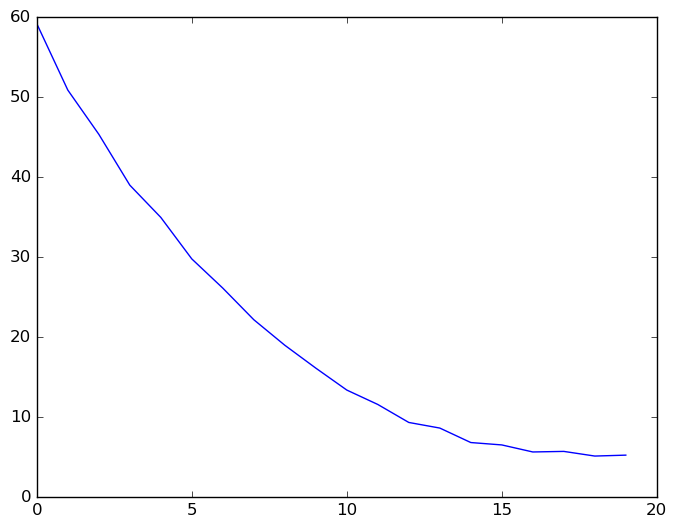

  1.968775 seconds (10.94 M allocations: 388.268 MB, 3.41% gc time)


1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f02ff8ea050>

In [19]:
f = x -> energy_cost(x, point)

cost_and_gradient = x -> begin
    out = ForwardDiff.GradientResult(x)
    ForwardDiff.gradient!(out, f, x)
    ForwardDiff.value(out), ForwardDiff.gradient(out)
end

energies = []
alpha = 0.98
# Profile.clear()
@time for i = 1:20
    ci, gi = cost_and_gradient(x)
    if any(isnan, gi)
        @show gi
        error("nan in gradient")
    end
    step = -ci ./ gi
    step = sign(step) .* min.(0.01, abs.(gi))
    x += alpha^i .* step
#     x -= step * gi
    draw(robot, map(value, x))

    LCMGLClient("normals") do lcmgl
        color(lcmgl, 0,0,0)
    
        state = convert(SoftRobots.SoftRobotState{Float64}, map(value, x))
        for i = 1:length(state.positions)
            sphere(lcmgl, convert(Vector, state.positions[i]), 0.02, 10, 10)
        end
        begin_mode(lcmgl, LCMGL.LINES)
        for edge in robot.edges
            vertex(lcmgl, state.positions[edge.parent]...)
            vertex(lcmgl, state.positions[edge.child]...)
        end
        end_mode(lcmgl)
        
        color(lcmgl, 0, 1, 0)
        for i = 1:2
            sphere(lcmgl, convert(Vector, state.positions[i]), 0.05, 10, 10)
        end
        switch_buffer(lcmgl)
    end
    push!(energies, ci)
end
# ProfileView.view()
PyPlot.plot(energies)
